In [60]:
import numpy as np
import scipy.io
from scipy.io import loadmat
import sklearn.model_selection
import pandas as pd
import matplotlib.pyplot as plt

In [45]:
# import spam data
spam_data = loadmat("hw5_code/dataset/spam/spam_data.mat")
spam_X = spam_data.get('training_data')
spam_y = spam_data.get('training_labels').flatten()
spam_X_test = spam_data.get('test_data')

In [46]:
# spam train-val split
np.random.seed(42)
inds = np.random.permutation(len(spam_X))
spam_X_val = spam_X[inds][:1000]
spam_y_val = spam_y[inds][:1000]

spam_X = spam_X[inds][1000:]
spam_y = spam_y[inds][1000:]

In [47]:
# import titanic data
df_titanic_X = pd.read_csv('hw5_code/dataset/titanic/titanic_training.csv')
df_titanic_y = df_titanic_X['survived']
df_titanic_test = pd.read_csv('hw5_code/dataset/titanic/titanic_test_data.csv')

In [48]:
# titanic preprocessing
df_titanic_X = df_titanic_X.drop(labels = ['survived', 'cabin', 'embarked', 'ticket'], axis=1)
df_titanic_test = df_titanic_test.drop(labels = ['cabin', 'embarked', 'ticket'], axis=1)

df_titanic_test["rels"] = df_titanic_test["sibsp"] + df_titanic_test["parch"]
df_titanic_test = df_titanic_test.drop(labels = ['sibsp', 'parch'], axis=1)

df_titanic_X["rels"] = df_titanic_X["sibsp"] + df_titanic_X["parch"]
df_titanic_X = df_titanic_X.drop(labels = ['sibsp', 'parch'], axis=1)

cat_feats = ["sex"]
num_feats = ["pclass", "age", "fare", "rels"]

def preprocessing(df):

    for col in num_feats:
        df[col] = df[col].fillna(np.mean(df[col]))

    cat_feats_dumms = pd.get_dummies(df[cat_feats])
    df = df.drop(labels=cat_feats, axis=1)

    return pd.concat([df, cat_feats_dumms], axis=1)

df_titanic_X = preprocessing(df_titanic_X)
df_titanic_test = preprocessing(df_titanic_test)

In [11]:
# titanic train-val split
titanic_X = df_titanic_X.to_numpy()
titanic_y = df_titanic_y.to_numpy()
titanic_test = df_titanic_test.to_numpy()

np.random.seed(42)
inds = np.random.permutation(len(titanic_X))
titanic_X_val = titanic_X[inds][:300]
titanic_y_val = titanic_y[inds][:300]

titanic_X = titanic_X[inds][300:]
titanic_y = titanic_y[inds][300:]

# Implement Descision Trees

In [13]:
def information_gain(y0, y1, curr_H):
    p0 = len(y0) / (len(y0) + len(y1))
    p1 = 1 - p0
    return curr_H - (p0*gini_impurity(y0) + p1*gini_impurity(y1))

def gini_impurity(y):
    labels = np.unique(y)
    gini = 1
    for label in labels:
        p = np.sum([label == a for a in y]) / len(y)
        gini -= p**2
    return gini

In [114]:
class DecisionTree:
    def __init__(self, max_depth=3, feats=None, sample_feats=False, visualize_tree=False, visualize_path=False):
        self.max_depth = max_depth
        self.sample_feats = sample_feats
        self.left, self.right = None, None  # for non-leaf nodes
        self.split_idx, self.thresh = None, None  # for non-leaf nodes
        self.data, self.pred = None, None  # for leaf nodes
        self.feats = feats
        self.visualize_path = visualize_path
        self.visualize_tree = visualize_tree

    def split(self, X, y, idx, thresh):
        X0, idx0, X1, idx1 = self.split_test(X, idx=idx, thresh=thresh)
        y0, y1 = y[idx0], y[idx1]
        return X0, y0, X1, y1

    def split_test(self, X, idx, thresh):
        idx0 = np.where(X[:, idx] < thresh)[0]
        idx1 = np.where(X[:, idx] >= thresh)[0]
        X0, X1 = X[idx0, :], X[idx1, :]
        return X0, idx0, X1, idx1
    
    def best_split(self, X, y):
        curr_H = gini_impurity(y)
        max_gain = 0
        best_feat = None
        best_thresh = -1
        features = range(X.shape[1])
        if self.sample_feats:
            m = int(X.shape[1]**(1/2))
            features = np.random.choice(features, size=m, replace=False)
        for feat in features:
            for thresh in np.unique(X[:, feat]):
                X0, y0, X1, y1 = self.split(X=X, y=y, idx=feat, thresh=thresh)
                curr_gain = information_gain(y0, y1, curr_H)
                if curr_gain > max_gain:
                    max_gain = curr_gain
                    best_feat = feat
                    best_thresh = thresh
        self.split_idx = best_feat
        self.thresh = best_thresh
        return self.split(X=X, y=y, idx=best_feat, thresh=best_thresh)

    def fit(self, X, y):
        if self.max_depth > 0:
            X0, y0, X1, y1 = self.best_split(X, y)
            if X0.size > 0 and X1.size > 0:
                self.left = DecisionTree(
                    max_depth=self.max_depth - 1, sample_feats=self.sample_feats, visualize_path=self.visualize_path, 
                    feats=self.feats)
                self.left.fit(X0, y0)
                self.right = DecisionTree(
                    max_depth=self.max_depth - 1, sample_feats=self.sample_feats, visualize_path=self.visualize_path,
                    feats=self.feats)
                self.right.fit(X1, y1)
            else:
                self.max_depth = 0
                self.data, self.labels = X, y
                self.pred = stats.mode(y).mode[0]
        else:
            self.data, self.labels = X, y
            self.pred = stats.mode(y).mode[0]
        return self

    def predict(self, X):
        if self.max_depth == 0:
            return self.pred * np.ones(X.shape[0])
        else:
            X0, idx0, X1, idx1 = self.split_test(X, idx=self.split_idx, thresh=self.thresh)
            yhat = np.zeros(X.shape[0])
            yhat[idx0] = self.left.predict(X0)
            yhat[idx1] = self.right.predict(X1)
            return yhat
        
    def __repr__(self):
        if self.max_depth == 0:
            return "%s (%s)" % (self.pred, self.labels.size)
        else:
            return "[%s < %s: %s | %s]" % (self.feats[self.split_idx],
                                           self.thresh, self.left.__repr__(),
                                           self.right.__repr__())

# Implement a Random Forest

In [15]:
class RandomForest:
    def __init__(self, max_depth=10, n=15):
        self.max_depth = max_depth
        self.n = n
        self.decision_trees = [DecisionTree(max_depth=self.max_depth, sample_feats=True) for i in range(self.n)]
        
    def fit(self, X, y):
        for i in range(self.n):
            inds = np.random.choice(range(X.shape[0]), size=X.shape[0], replace=True)
            bag_X = X[inds]
            bag_y = y[inds]
            self.decision_trees[i].fit(bag_X, bag_y)
        return self
    
    def predict(self, X):
        preds = [tree.predict(X) for tree in self.decision_trees]
        preds = np.array(preds)
        final_pred = stats.mode(preds).mode
        return final_pred.flatten()
            

# Examples and Performance Evaluation

In [45]:
# import spam data
spam_data = loadmat("dataset/spam/spam_data.mat")
spam_X = spam_data.get('training_data')
spam_y = spam_data.get('training_labels').flatten()
spam_X_test = spam_data.get('test_data')

In [46]:
# spam train-val split
np.random.seed(42)
inds = np.random.permutation(len(spam_X))
spam_X_val = spam_X[inds][:1000]
spam_y_val = spam_y[inds][:1000]

spam_X = spam_X[inds][1000:]
spam_y = spam_y[inds][1000:]

In [47]:
# import titanic data
df_titanic_X = pd.read_csv('dataset/titanic/titanic_training.csv')
df_titanic_y = df_titanic_X['survived']
df_titanic_test = pd.read_csv('hw5_code/dataset/titanic/titanic_test_data.csv')

In [48]:
# titanic preprocessing
df_titanic_X = df_titanic_X.drop(labels = ['survived', 'cabin', 'embarked', 'ticket'], axis=1)
df_titanic_test = df_titanic_test.drop(labels = ['cabin', 'embarked', 'ticket'], axis=1)

df_titanic_test["rels"] = df_titanic_test["sibsp"] + df_titanic_test["parch"]
df_titanic_test = df_titanic_test.drop(labels = ['sibsp', 'parch'], axis=1)

df_titanic_X["rels"] = df_titanic_X["sibsp"] + df_titanic_X["parch"]
df_titanic_X = df_titanic_X.drop(labels = ['sibsp', 'parch'], axis=1)

cat_feats = ["sex"]
num_feats = ["pclass", "age", "fare", "rels"]

def preprocessing(df):

    for col in num_feats:
        df[col] = df[col].fillna(np.mean(df[col]))

    cat_feats_dumms = pd.get_dummies(df[cat_feats])
    df = df.drop(labels=cat_feats, axis=1)

    return pd.concat([df, cat_feats_dumms], axis=1)

df_titanic_X = preprocessing(df_titanic_X)
df_titanic_test = preprocessing(df_titanic_test)

In [11]:
# titanic train-val split
titanic_X = df_titanic_X.to_numpy()
titanic_y = df_titanic_y.to_numpy()
titanic_test = df_titanic_test.to_numpy()

np.random.seed(42)
inds = np.random.permutation(len(titanic_X))
titanic_X_val = titanic_X[inds][:300]
titanic_y_val = titanic_y[inds][:300]

titanic_X = titanic_X[inds][300:]
titanic_y = titanic_y[inds][300:]

In [17]:
spam_model = DecisionTree(max_depth = 8)
spam_model.fit(spam_X, spam_y)
spam_X_preds = spam_model.predict(spam_X)
spam_X_acc = sum(spam_X_preds == spam_y) / len(spam_y)
spam_val_preds = spam_model.predict(spam_X_val)
spam_val_acc = sum(spam_val_preds == spam_y_val) / len(spam_y_val)
print("Decision Tree Spam Train Accuracy:", spam_X_acc)
print("Decision Tree Spam Validation Accuracy:", spam_val_acc)

/var/folders/c7/jkk8dncs2y35yqy53f3511nh0000gn/T/ipykernel_2623/3963986499.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self.pred = stats.mode(y).mode[0]
/var/folders/c7/jkk8dncs2y35yqy53f3511nh0000gn/T/ipykernel_2623/3963986499.py:54: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False

Decision Tree Spam Train Accuracy: 0.8521028037383177
Decision Tree Spam Validation Accuracy: 0.819


In [18]:
spam_model_r = RandomForest(max_depth=10, n=200)
spam_model_r.fit(spam_X, spam_y)
spam_X_preds_r = spam_model_r.predict(spam_X)
spam_X_acc_r = sum(spam_X_preds_r == spam_y) / len(spam_y)
spam_val_preds_r = spam_model_r.predict(spam_X_val)
spam_val_acc_r = sum(spam_val_preds_r == spam_y_val) / len(spam_y_val)
print("Random Forest Spam Train Accuracy:", spam_X_acc_r)
print("Random Forest Spam Validation Accuracy:", spam_val_acc_r)

/var/folders/c7/jkk8dncs2y35yqy53f3511nh0000gn/T/ipykernel_2623/3963986499.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self.pred = stats.mode(y).mode[0]
/var/folders/c7/jkk8dncs2y35yqy53f3511nh0000gn/T/ipykernel_2623/3963986499.py:54: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False

Random Forest Spam Train Accuracy: 0.852803738317757
Random Forest Spam Validation Accuracy: 0.828


In [26]:
titanic_model = DecisionTree(max_depth = 4)
titanic_model.fit(titanic_X, titanic_y)
titanic_X_preds = titanic_model.predict(titanic_X)
titanic_X_acc = sum(titanic_X_preds == titanic_y) / len(titanic_y)
titanic_val_preds = titanic_model.predict(titanic_X_val)
titanic_val_acc = sum(titanic_val_preds == titanic_y_val) / len(titanic_y_val)
print("Decision Tree Titanic Train Accuracy:", titanic_X_acc)
print("Decision Tree Titanic Validation Accuracy:", titanic_val_acc)

/var/folders/c7/jkk8dncs2y35yqy53f3511nh0000gn/T/ipykernel_2623/3963986499.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self.pred = stats.mode(y).mode[0]
/var/folders/c7/jkk8dncs2y35yqy53f3511nh0000gn/T/ipykernel_2623/3963986499.py:54: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False

Decision Tree Titanic Train Accuracy: 0.8342857142857143
Decision Tree Titanic Validation Accuracy: 0.78


In [31]:
titanic_model_r = RandomForest(max_depth=8, n=500)
titanic_model_r.fit(titanic_X, titanic_y)
titanic_X_preds_r = titanic_model_r.predict(titanic_X)
titanic_X_acc_r = sum(titanic_X_preds_r == titanic_y) / len(titanic_y)
titanic_val_preds_r = titanic_model_r.predict(titanic_X_val)
titanic_val_acc_r = sum(titanic_val_preds_r == titanic_y_val) / len(titanic_y_val)
print("Random Forest Titanic Train Accuracy:", titanic_X_acc_r)
print("Random Forest Titanic Validation Accuracy:", titanic_val_acc_r)

/var/folders/c7/jkk8dncs2y35yqy53f3511nh0000gn/T/ipykernel_2623/3963986499.py:54: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self.pred = stats.mode(y).mode[0]
/var/folders/c7/jkk8dncs2y35yqy53f3511nh0000gn/T/ipykernel_2623/3963986499.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False

Random Forest Titanic Train Accuracy: 0.8357142857142857
Random Forest Titanic Validation Accuracy: 0.78


In [36]:
# spam kaggle submission
spam_test_model = RandomForest(max_depth=10, n=200)
spam_test_model.fit(spam_X, spam_y)
spam_test_preds = spam_test_model.predict(spam_X_test)

/var/folders/c7/jkk8dncs2y35yqy53f3511nh0000gn/T/ipykernel_2623/3963986499.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self.pred = stats.mode(y).mode[0]
/var/folders/c7/jkk8dncs2y35yqy53f3511nh0000gn/T/ipykernel_2623/3963986499.py:54: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False

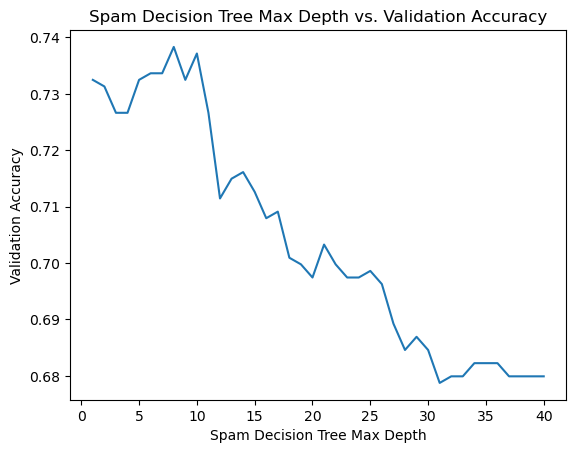

In [62]:
plt.plot(range(1,41), spam_val_acts)
plt.xlabel("Spam Decision Tree Max Depth")
plt.ylabel("Validation Accuracy")
plt.title("Spam Decision Tree Max Depth vs. Validation Accuracy")
plt.show()